In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns

#### Transformation 1 : Data augmentation with wealth data

In [45]:
energy = pd.read_csv("../Data/energy.csv")
wealth = pd.read_csv("../Data/wealth.csv")
idcols = [
    'Country',
    'Year',
    'Region'
]
rencols = [
    "electbyfuel_hydro",
    "hydro_ej",
    "biofuels_prod_pj",
    "biofuels_cons_pj",
]
wealthcols = [
    'GDP per capita, PPP (current international $)',
    'GDP, PPP (current international $)',
]

In [46]:
df = pd.merge(energy[idcols + rencols], wealth[(['Country', 'Year'] + wealthcols)], on = ['Country', 'Year'])
df.rename(columns={
    'GDP per capita, PPP (current international $)' : 'GDP_PPP_percap',
    'GDP, PPP (current international $)' : 'GDP_PPP'
}, inplace = True)
wealthcols = [
    'GDP_PPP_percap',
    'GDP_PPP'
]
df

,Country,Year,Region,electbyfuel_hydro,hydro_ej,biofuels_prod_pj,biofuels_cons_pj,GDP_PPP_percap,GDP_PPP
0,Algeria,1980,Africa,0.0,0.002736,0.0,0.0,0.000000,0.000000e+00
1,Algeria,1981,Africa,0.0,0.003896,0.0,0.0,0.000000,0.000000e+00
2,Algeria,1982,Africa,0.0,0.005099,0.0,0.0,0.000000,0.000000e+00
3,Algeria,1983,Africa,0.0,0.002502,0.0,0.0,0.000000,0.000000e+00
4,Algeria,1984,Africa,0.0,0.004812,0.0,0.0,0.000000,0.000000e+00
...,...,...,...,...,...,...,...,...,...
3005,Uzbekistan,2018,CIS,0.0,0.056170,0.0,0.0,7289.329501,2.402279e+11
3006,Uzbekistan,2019,CIS,0.0,0.061322,0.0,0.0,7717.744117,2.591645e+11
3007,Uzbekistan,2020,CIS,0.0,0.047266,0.0,0.0,7822.661958,2.677858e+11
3008,Uzbekistan,2021,CIS,0.0,0.047196,0.0,0.0,8607.527450,3.005327e+11


In [47]:
df.loc[1000]

Country                           Germany
Year                                 1991
Region                             Europe
electbyfuel_hydro                   15.85
hydro_ej                         0.168726
biofuels_prod_pj                      0.0
biofuels_cons_pj                      0.0
GDP_PPP_percap               20996.187697
GDP_PPP              1679986778764.659912
Name: 1000, dtype: object

In [48]:
### using a modified Data Preprocessor class based off /Harsh/main.py

class Data:
    def __init__(self, df, year):
        self.df = df.copy()
        self.imputer = SimpleImputer(strategy="mean")
        self.encoder = OrdinalEncoder()
        self.year = year
        self.X = df.copy()
        self.X = self.get_year(year)
        # self.w_o_outliers = self.remove_all_outliers()
        
    def plot_outliers(self):
        pltdata = [
            len(self.w_o_outliers),
            len(self.X) - len(self.w_o_outliers)
        ]
        plt.pie(pltdata, labels = [f"Not Outliers - {pltdata[0]}", f"Outliers - {pltdata[1]}"])
        plt.show()

        
    def plot_outliers_for_col(self):
        figure, axis = plt.subplots(1, 2, figsize = (10, 6))
        pos = 0
        for col in wealthcols:
            axis[pos].set_title(f"Outliers for {col}", fontsize = 15)
            axis[pos].boxplot(self.X[col])
            pos += 1
        figure.tight_layout(pad = 1.0)
        plt.show()

    def get_year(self, year):
        grouped_data = self.X.groupby(['Year'])
        grouped_data.get_group(year)
        return grouped_data.get_group(year)
    
    def show_outliers(self, column):
        try:
            sns.boxplot(x=self.X[column])
            plt.show()
        except:
            print("There was some error while accessing the given column")

    def IQR(self):
        reqcols = []
        for col in self.X.columns:
            if col in idcols + ["torem"]: 
                continue
            reqcols.append(col)
        temp1 = self.X[reqcols].copy()
        temp2 = self.X[reqcols].copy()
        Q1 = (temp1).quantile(0.25)
        Q3 = (temp2).quantile(0.75)
        iqr = Q3-Q1
        return (Q1, Q3, iqr)
    
    def remove_all_outliers(self):
        Q1, Q3, IQR = self.IQR()
        prev = len(self.X.index)
        self.X["torem"] = True
        for col in self.X.columns:
            if col in idcols + ["torem"]:
                continue
            mask = ~((self.X[col] < (Q1[col] - 1.5 * IQR[col])) | (self.X[col] > (Q3[col] + 1.5 * IQR[col])))
            self.X['torem'] &= mask
        outliers_count = (self.X['torem'] == False).sum()
        print(f"{outliers_count} outliers were detected")
        return self.X[self.X["torem"]]
    
    def remove_outliers(self, col):
        sorts = self.X[col].sort_values()
        Q1 = sorts.quantile(0.25)
        Q3 = sorts.quantile(0.75)
        IQR = Q3-Q1
        prev = len(self.X.index)
        return sorts[~((sorts < (Q1 - 1.5 * IQR)) |
                         (sorts > (Q3 + 1.5 * IQR)))]
def scale(data):
    return data/max(data)

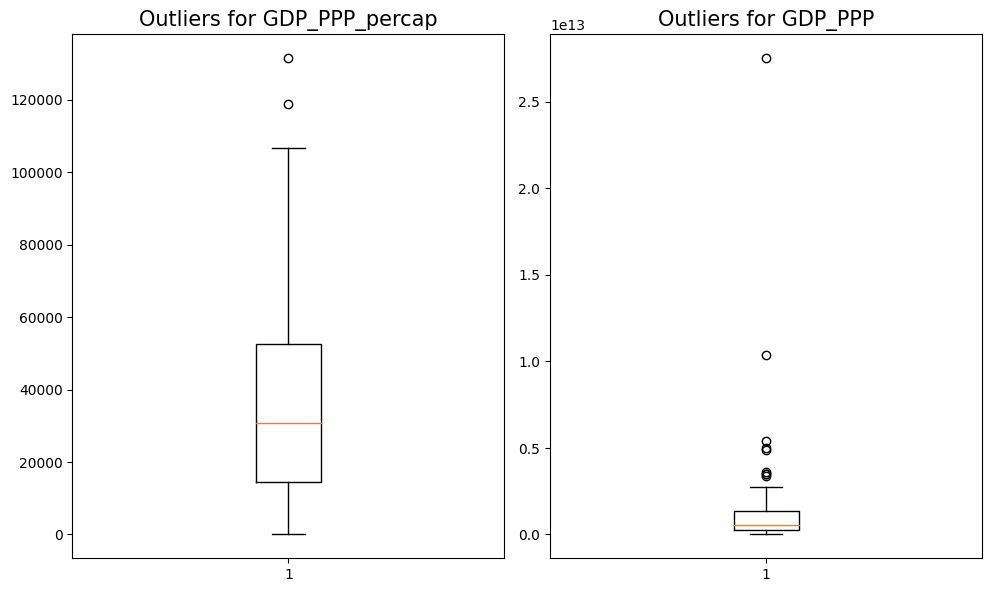

In [49]:
data = Data(df, year = 2021)
data.plot_outliers_for_col()

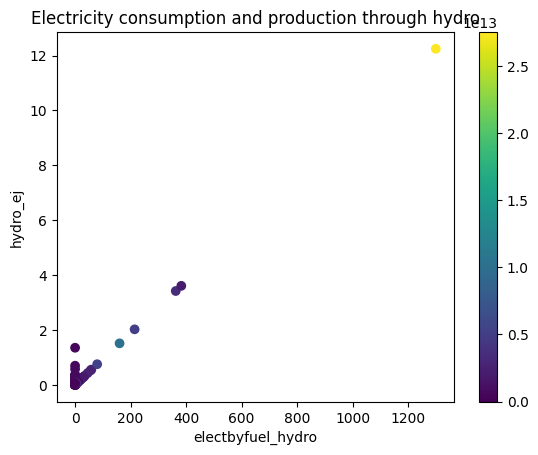

In [50]:
### Scatter plot color mapped according to GDP

def plotScatter(data, x, y, c, title):
    plt.scatter(data[x], data[y], c = data[c])
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.colorbar()
    plt.show()
    
plotScatter(data.X, "electbyfuel_hydro", "hydro_ej", "GDP_PPP", "Electricity consumption and production through hydro")

In [51]:
df.head()

,Country,Year,Region,electbyfuel_hydro,hydro_ej,biofuels_prod_pj,biofuels_cons_pj,GDP_PPP_percap,GDP_PPP
0,Algeria,1980,Africa,0.0,0.002736,0.0,0.0,0.0,0.0
1,Algeria,1981,Africa,0.0,0.003896,0.0,0.0,0.0,0.0
2,Algeria,1982,Africa,0.0,0.005099,0.0,0.0,0.0,0.0
3,Algeria,1983,Africa,0.0,0.002502,0.0,0.0,0.0,0.0
4,Algeria,1984,Africa,0.0,0.004812,0.0,0.0,0.0,0.0


16 outliers were detected


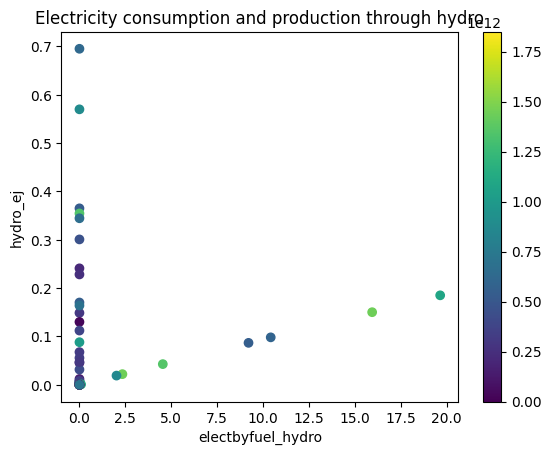

In [52]:
data = Data(df[idcols + ["electbyfuel_hydro", "hydro_ej", "GDP_PPP"]], year=2021)
plotScatter(
    data.remove_all_outliers(),
    "electbyfuel_hydro",
    "hydro_ej",
    "GDP_PPP",
    "Electricity consumption and production through hydro",
)

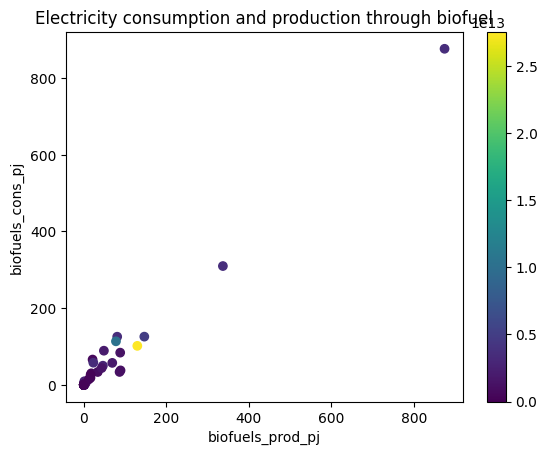

In [53]:
data = Data(df[idcols + ["biofuels_prod_pj", "biofuels_cons_pj", "GDP_PPP"]], year=2021)
plotScatter(
    data.X,
    "biofuels_prod_pj",
    "biofuels_cons_pj",
    "GDP_PPP",
    "Electricity consumption and production through biofuel",
)

17 outliers were detected


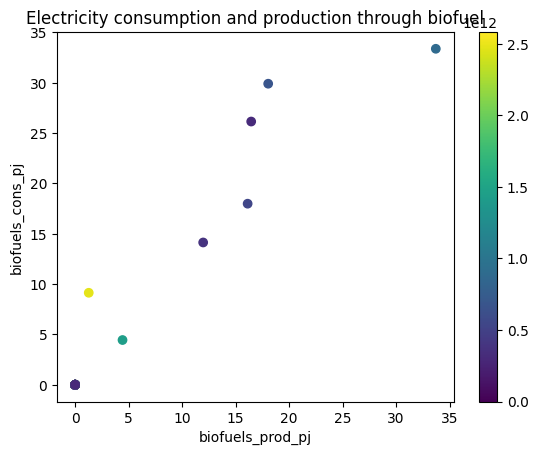

In [54]:
plotScatter(
    data.remove_all_outliers(),
    "biofuels_prod_pj",
    "biofuels_cons_pj",
    "GDP_PPP",
    "Electricity consumption and production through biofuel",
)

#### Transformation 3 : Total Production over the years

In [55]:
wealthcols = [
    'Country', 'Year',
    'GDP, PPP (current international $)'
]
timeSeriesData = pd.merge(energy[idcols + rencols], wealth[wealthcols], on = ['Country', 'Year']).groupby('Year').sum()
timeSeriesData.rename(columns={
    'GDP, PPP (current international $)' : 'GDP_PPP'
}, inplace = True)
wealthcols = [
    'GDP_PPP_percap',
    'GDP_PPP'
]
timeSeriesData.head()

,Country,Region,electbyfuel_hydro,hydro_ej,biofuels_prod_pj,biofuels_cons_pj,GDP_PPP
Year,,,,,,,
1980,AlgeriaAngolaArgentinaAustraliaAustriaAzerbaij...,AfricaAfricaS. & Cent. AmericaAsia PacificEuro...,813.510242,12.001742,0.0,70.058033,0.0
1981,AlgeriaAngolaArgentinaAustraliaAustriaAzerbaij...,AfricaAfricaS. & Cent. AmericaAsia PacificEuro...,845.849539,12.513821,0.0,64.143874,0.0
1982,AlgeriaAngolaArgentinaAustraliaAustriaAzerbaij...,AfricaAfricaS. & Cent. AmericaAsia PacificEuro...,844.177133,12.472357,0.0,89.300849,0.0
1983,AlgeriaAngolaArgentinaAustraliaAustriaAzerbaij...,AfricaAfricaS. & Cent. AmericaAsia PacificEuro...,869.713038,12.995003,0.0,128.298000,0.0
1984,AlgeriaAngolaArgentinaAustraliaAustriaAzerbaij...,AfricaAfricaS. & Cent. AmericaAsia PacificEuro...,909.216725,13.487045,0.0,158.905119,0.0


In [56]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
timeSeriesData[rencols + ['GDP_PPP']] = scaler.fit_transform(timeSeriesData[rencols + ['GDP_PPP']])
    
timeSeriesData.head()

,Country,Region,electbyfuel_hydro,hydro_ej,biofuels_prod_pj,biofuels_cons_pj,GDP_PPP
Year,,,,,,,
1980,AlgeriaAngolaArgentinaAustraliaAustriaAzerbaij...,AfricaAfricaS. & Cent. AmericaAsia PacificEuro...,0.000000,0.000000,0.0,0.002510,0.0
1981,AlgeriaAngolaArgentinaAustraliaAustriaAzerbaij...,AfricaAfricaS. & Cent. AmericaAsia PacificEuro...,0.015179,0.024108,0.0,0.000000,0.0
1982,AlgeriaAngolaArgentinaAustraliaAustriaAzerbaij...,AfricaAfricaS. & Cent. AmericaAsia PacificEuro...,0.014394,0.022156,0.0,0.010676,0.0
1983,AlgeriaAngolaArgentinaAustraliaAustriaAzerbaij...,AfricaAfricaS. & Cent. AmericaAsia PacificEuro...,0.026380,0.046762,0.0,0.027225,0.0
1984,AlgeriaAngolaArgentinaAustraliaAustriaAzerbaij...,AfricaAfricaS. & Cent. AmericaAsia PacificEuro...,0.044922,0.069927,0.0,0.040213,0.0


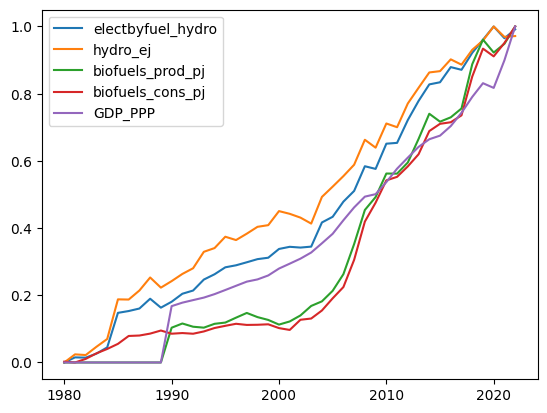

In [57]:
for col in (rencols + ['GDP_PPP']):
    plt.plot(timeSeriesData.index, timeSeriesData[col], label = col)
plt.legend()
plt.show()